### Desafío - Inferencia de tópicos con EM

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip

### Descripción
* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.
* Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción. Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump .
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
plt.style.use('seaborn')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
rutas = glob.glob(os.getcwd()+'/dump/*.csv')
datas = []
for ruta in rutas:
    df = pd.read_csv(ruta).drop(columns='Unnamed: 0')
    datas.append(df)

In [4]:
df = pd.concat(datas)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9489 entries, 0 to 129
Data columns (total 4 columns):
0    9489 non-null object
1    9489 non-null object
2    9489 non-null object
3    9489 non-null object
dtypes: object(4)
memory usage: 370.7+ KB


In [5]:
df.columns=['Artista','Genero','Cancion','Letra']
df.head()

Artista  Genero                 Cancion  \
0  Public Enemy  hiphop  You're Gonna Get Yours   
1  Public Enemy  hiphop     Sophisticated Bitch   
2  Public Enemy  hiphop      Miuzi Weighs A Ton   
3  Public Enemy  hiphop                Timebomb   
4  Public Enemy  hiphop          Too Much Posse   

                                               Letra  
0  (Flavor Flav) \n Oh-oh Chuck, they out to get ...  
1  That woman in the corner, cold playin' the rol...  
2  Yo Chuck, run a power move on them \n (Yeah) \...  
3  (Intro - Flavor Flav) \n Hey, Chuck, we got so...  
4  (Intro - Flavor Flav) \n What do you got to sa...

In [6]:
df.Genero.value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: Genero, dtype: int64

### Ejercicio 2: Matriz de ocurrencias
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn .
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
* Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

### Ejercicio 3: Entrenamiento del Modelo
* Importe sklearn.decomposition.LatentDirichletAllocation y sklearn.model_selection.GridSearchCV .
* Genere una búsqueda de grilla con los siguientes hiperparámetros:
    * n_components: [5, 10, 15] .
    * learning_decay: [0.7, 0.5] .
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer .
* Reporte brevemente cuál es la mejor combinación de hiperparámetros

##### Digresión: Latent Dirichlet Allocation
* Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. La principal utilidad de éste es la identificación de tópicos en un corpus de texto. 
* El proceso de inferencia se puede resumir en los siguientes pasos:
    * Cada documento dentro del corpus se puede entender como una mezcla de tópicos comunes a nivel de corpus.
    * Esta mezcla de tópicos es latente $\leadsto$ Sólo observamos los documentos registrados y sus palabras. La API de sklearn.decomposition.LatentDirichletAllocation presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:
        * n_components : Cantidad de tópicos a inferir en un corpus.
        * learning_method : Forma en la que entran los datos en entrenamiento. Cuando es 'batch' , se ingresa la matriz de entrenamiento completa. Cuando es 'online' , la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.
        * learning_decay : Tasa de aprendizaje en la función de pérdida. Cuando se implementa con learning_method='online', el modelo se entrena con Gradiente Estocástico Descendente.
        * Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En funcion a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [9]:
lda = LatentDirichletAllocation(learning_method='online')

In [10]:
count_vectorizer=CountVectorizer(stop_words='english',max_features=5000)
count_vectorizer_fit = count_vectorizer.fit_transform(df.Letra)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(df['Letra'],df['Genero'],test_size=.33,random_state=11238)

In [12]:
parameter_candidates = [
  {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}
]

In [13]:
grid = GridSearchCV(lda, parameter_candidates, cv=2, n_jobs=-1)

In [25]:
%%time
grid.fit(count_vectorizer_fit)

CPU times: user 2min 19s, sys: 2.43 s, total: 2min 22s
Wall time: 5min 42s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                       

In [26]:
grid.best_params_

{'learning_decay': 0.7, 'n_components': 5}

### Ejercicio 4 : Inferencia e Identificación de Tópicos
* En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

```python
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.

for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))
```

* Comente a qué tópicos está asociada cada clase inferida.

In [27]:
for topic_id, topic_name in enumerate(grid.best_estimator_.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
don know just got ll like want say ve time cause let gonna make way
tópico: 2
love oh yeah baby come hey ooh girl ah let night tonight got ll like
tópico: 3
shit like fuck nigga yeah niggas ain got bitch ya don la yo ass know
tópico: 4
like got man yo em cause ain don know just shit new make right black
tópico: 5
life world god ll eyes away time die death light dead blood day soul heart


tópico: 1

    Genero mas neutral, puede ser rock sube o pop
tópico: 2

    Es de topico romantica, posiblemente rock romantico
tópico: 3

    Es de tipo mas urbano, muy probable rap
tópico: 4

    Al igual que el topico 1 es algo dificil ubicarlo un un topico
tópico: 5

    Tema mas oscuro, probablemente metal

### Ejercicio 5: Identificación de probabilidades
* En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. 
* Podemos implementar esto de la siguiente manera:
    
```python    
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
                                    # pasamos esta matriz y la redondeamos en 3 decimales
                                    np.round(fit_best_lda, 3),
                                    # agregamos un índice
                                    index=df_lyrics.index
                                    )
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(docs_topics.values, axis=1) + 1   

```

* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.

* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.

* Grafique la distribución de las probabilidades para algún artista en específico.

In [28]:
fit_best_lda = grid.best_estimator_.transform(count_vectorizer_fit)

In [29]:
fit_best_lda

array([[3.12832340e-01, 8.02214986e-04, 8.00575740e-04, 6.57093654e-01,
        2.84712153e-02],
       [3.98254480e-01, 9.68753129e-04, 1.17754281e-01, 4.10393405e-01,
        7.26290809e-02],
       [8.36375897e-02, 2.16959369e-02, 8.56505073e-04, 8.71425468e-01,
        2.23845000e-02],
       ...,
       [2.93586413e-01, 8.12774318e-04, 8.03817865e-04, 7.03990995e-01,
        8.05999816e-04],
       [7.24605227e-04, 7.28742790e-04, 8.20964325e-01, 1.04055910e-01,
        7.35264172e-02],
       [7.25105045e-02, 8.50234247e-04, 3.93292467e-02, 8.02744721e-01,
        8.45652940e-02]])

In [30]:
topics_for_each_doc = pd.DataFrame(
                                    # pasamos esta matriz y la redondeamos en 3 decimales
                                    np.round(fit_best_lda, 3),
                                    # agregamos un índice
                                    index=df.index
                                    )

In [31]:
topics_for_each_doc.head()

0      1      2      3      4
0  0.313  0.001  0.001  0.657  0.028
1  0.398  0.001  0.118  0.410  0.073
2  0.084  0.022  0.001  0.871  0.022
3  0.196  0.064  0.001  0.738  0.001
4  0.236  0.036  0.092  0.561  0.075

In [32]:
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, grid.best_estimator_.n_components + 1)))

In [33]:
topics_for_each_doc.head()

T: 1   T: 2   T: 3   T: 4   T: 5
0  0.313  0.001  0.001  0.657  0.028
1  0.398  0.001  0.118  0.410  0.073
2  0.084  0.022  0.001  0.871  0.022
3  0.196  0.064  0.001  0.738  0.001
4  0.236  0.036  0.092  0.561  0.075

In [34]:
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)

In [35]:
concatenated_df

Artista  Genero                                            Cancion  \
0    Public Enemy  hiphop                             You're Gonna Get Yours   
1    Public Enemy  hiphop                                Sophisticated Bitch   
2    Public Enemy  hiphop                                 Miuzi Weighs A Ton   
3    Public Enemy  hiphop                                           Timebomb   
4    Public Enemy  hiphop                                     Too Much Posse   
5    Public Enemy  hiphop              Rightstarter (Message To A Black Man)   
6    Public Enemy  hiphop                                 Public Enemy No. 1   
7    Public Enemy  hiphop                                             M.P.E.   
8    Public Enemy  hiphop                              Yo! Bum Rush The Show   
9    Public Enemy  hiphop                                     Raise The Roof   
10   Public Enemy  hiphop                                          Megablast   
11   Public Enemy  hiphop                 Terminator X Speaks With His Hands   
12   Public Enemy  hiphop                                    Bring The Noise   
13   Public Enemy  hiphop                             Don't Believe The Hype   
14   Public Enemy  hiphop                           Cold Lampin' With Flavor   
15   Public Enemy  hiphop                  Terminator X To The Edge Of Panic   
16   Public Enemy  hiphop                                     Mind Terrorist   
17   Public Enemy  hiphop                                 Louder Than A Bomb   
18   Public Enemy  hiphop                      Caught, Can We Get A Witness?   
19   Public Enemy  hiphop                               Show 'Em Whatcha Got   
20   Public Enemy  hiphop                           She Watch Channel Zero?!   
21   Public Enemy  hiphop                      Night Of The Living Baseheads   
22   Public Enemy  hiphop                   Black Steel In The Hour Of Chaos   
23   Public Enemy  hiphop                              Rebel Without A Pause   
24   Public Enemy  hiphop                                   Prophets Of Rage   
25   Public Enemy  hiphop                      Party For Your Right To Fight   
26   Public Enemy  hiphop                                    Fight The Power   
27   Public Enemy  hiphop                         Brothers Gonna Work It Out   
28   Public Enemy  hiphop                                      911 Is A Joke   
29   Public Enemy  hiphop                                Incident At 66.6 FM   
..            ...     ...                                                ...   
100       Mos Def  hiphop                                         Kalifornia   
101       Mos Def  hiphop                                     Little Brother   
102       Mos Def  hiphop                                         Maybellene   
103       Mos Def  hiphop                                  Mos Def Freestyle   
104       Mos Def  hiphop  Mos Def-Grown Man Business (Fresh Vintage Bott...   
105       Mos Def  hiphop                                    Ms. Fat Booty 2   
106       Mos Def  hiphop   Much Respect To Michael Jordan (Nike Commercial)   
107       Mos Def  hiphop                                             Nadine   
108       Mos Def  hiphop                                      Next Universe   
109       Mos Def  hiphop                          No Particular Place To Go   
110       Mos Def  hiphop                                              Oh No   
111       Mos Def  hiphop                                One Four Love Pt. 1   
112       Mos Def  hiphop                                One Four Love Pt. 2   
113       Mos Def  hiphop                                      Promised Land   
114       Mos Def  hiphop                                  She Wants To Move   
115       Mos Def  hiphop                                     Six Days Remix   
116       Mos Def  hiphop                                           Six Days   
117       Mos Def  hiphop                             Soundbombing Freestyle   
118       

In [37]:
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1 

In [39]:
concatenated_df.sample()

Artista Genero         Cancion  \
34  Meshuggah  metal  Glints Collide   

                                                Letra   T: 1   T: 2   T: 3  \
34  Winds that shine a bright, blinding dark. Kero...  0.002  0.002  0.002   

     T: 4   T: 5  highest_topic  
34  0.002  0.991              5

Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.

Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.

Grafique la distribución de las probabilidades para algún artista en específico.

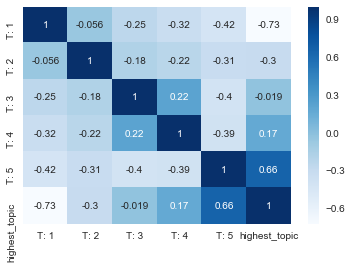

In [40]:
sns.heatmap(concatenated_df.corr(), cmap='Blues', annot=True);

Se observa que el que tiene una mayor probabilidad de ser  escogido es el topico 5 que se habia identificado como metal

In [68]:
#Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.
Artista = concatenated_df.sample()['Artista']
Artista = np.array(Artista)[0]
print('El artista correspode a:',Artista)
print('\nLas probabilidades a cada topico son')
concatenated_df[concatenated_df['Artista']==Artista]['highest_topic'].value_counts('%')

El artista correspode a: System of a Down

Las probabilidades a cada topico son


5    0.521368
1    0.256410
3    0.085470
2    0.085470
4    0.051282
Name: highest_topic, dtype: float64

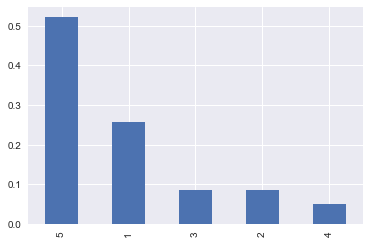

In [70]:
#Grafique la distribución de las probabilidades para algún artista en específico
concatenated_df[concatenated_df['Artista']==Artista]['highest_topic'].value_counts('%').plot(kind='bar')

##### Comentarios adicionales
Por tema de tiempo de ejecucion se realizo un modelo simple ya que se entiende que entre mas complejo sea este mas tiempo tardara en entrenarse y para temas pedagogicos se estimo que con un modelo simple en tiempo de computo era suficiente